<a href="https://colab.research.google.com/github/Schify/FacExcerciseBook/blob/andras/DL_Big_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#with this peace of code you can connect your drive with the google collab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#In the github repository we will provide the google drive link to the zip file
#containing the data that we will use. 
#This will unzip it into a train and a val folder
!unzip "gdrive/MyDrive/DL_big_homework/fairface" 

A streamkimeneten csak az utolsó 5000 sor látható.
  inflating: val/5370.jpg            
  inflating: val/5596.jpg            
  inflating: val/5875.jpg            
  inflating: val/5878.jpg            
  inflating: val/5879.jpg            
  inflating: val/5883.jpg            
  inflating: val/6126.jpg            
  inflating: val/6132.jpg            
  inflating: val/6144.jpg            
  inflating: val/6150.jpg            
  inflating: val/6340.jpg            
  inflating: val/7190.jpg            
  inflating: val/7734.jpg            
  inflating: val/7747.jpg            
  inflating: val/7872.jpg            
  inflating: val/7940.jpg            
  inflating: val/8065.jpg            
  inflating: val/8069.jpg            
  inflating: val/8125.jpg            
  inflating: val/8202.jpg            
  inflating: val/8204.jpg            
  inflating: val/8205.jpg            
  inflating: val/8268.jpg            
  inflating: val/8270.jpg            
  inflating: val/8281.jpg            

In [16]:
#loading all the necessary libraries for the project
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import cv2
from tqdm.notebook import tqdm #useful module for progress bars
import logging
import gc
from datetime import datetime
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.image import ImageDataGenerator
from skimage import io
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import CustomObjectScope
from tensorflow.keras.models import load_model

from keras_facenet import FaceNet
embedder = FaceNet()

In [14]:
!pip install keras_facenet

     |████████████████████████████████| 2.3 MB 6.0 MB/s 
  Created wheel for keras-facenet: filename=keras_facenet-0.3.2-py3-none-any.whl size=10386 sha256=e5a945b6f3f0a32eda7b41ab972bc4adf89327b3d2d6ca9f96a9b3b776ce39b1
  Stored in directory: /root/.cache/pip/wheels/2b/76/1a/a29ceb07bfca098e2b0bc8690d550753a0384cbed26d5f47ee
Successfully built keras-facenet


In [4]:
#here this is a function for loading the images from a given directory.
def load_all_images(directory, img_size = False, range_from = 0, range_to = 1):
    filenames = os.listdir(directory)
    num = len(filenames)
    resize = True
    if(not img_size):
        img = cv2.imread(os.path.join(directory,filenames[0]))
        img_size = img.shape[0]
        resize = False
    #For memory sizes this big dinamyc arrays (lists) are not an effective way to reserve memory
    #Hence numpy arrays are utalized
    print(f"{int(num*(range_to-range_from))} files to be loaded")
    start = int(num*range_from)
    images = np.zeros(shape=(int(num*(range_to-range_from)), img_size, img_size, 3), dtype=np.float16)
    w = 100
    num_none = 0
    for i in tqdm(range(int(images.shape[0]))):
        img = cv2.imread(os.path.join(directory,filenames[i+start]))
        if img is not None:

            if(resize):
                images[i, ...] = cv2.resize(img, (img_size, img_size))
            else:
                images[i, ...] = img
            '''
            w-=1
            if(__debug__ and w==0):
                break
        else:
            num_none +=1
'''
    if(num_none>0):
        print(f"{num_none} images were unable to load, or not valid image types")
    return images
#Here we used the garbage collector library to collect the pictures into a npz dataformat.
#we are splitting it into multiple batches and making the images 128x128 sizes.
#This way we are reserving memory and it's easier to load this later.
gc.collect()
np.savez("train_128x128_1_of_4.npz", train=load_all_images("train",
img_size=128,
range_from=0,
 range_to=0.25)
 )
gc.collect()
np.savez("train_128x128_2_of_4.npz", train=load_all_images("train",
img_size=128,
range_from=0.25,
 range_to=0.5)
 )
gc.collect()
np.savez("train_128x128_3_of_4.npz", train=load_all_images("train",
img_size=128,
range_from=0.5,
 range_to=0.75)
 )
gc.collect()
np.savez("train_128x128_4_of_4.npz", train=load_all_images("train",
img_size=128,
range_from=0.75,
 range_to=0.95)
 )

gc.collect()
np.savez("test_128x128.npz", train=load_all_images("train",
img_size=128,
range_from=0.95,
 range_to=1)
 )
gc.collect()
np.savez("val_128x128.npz", val=load_all_images("val",
img_size=128)
 )


21686 files to be loaded


  0%|          | 0/21686 [00:00<?, ?it/s]

21686 files to be loaded


  0%|          | 0/21686 [00:00<?, ?it/s]

21686 files to be loaded


  0%|          | 0/21686 [00:00<?, ?it/s]

17348 files to be loaded


  0%|          | 0/17348 [00:00<?, ?it/s]

4337 files to be loaded


  0%|          | 0/4337 [00:00<?, ?it/s]

10954 files to be loaded


  0%|          | 0/10954 [00:00<?, ?it/s]

In [6]:
#here we are dispalying the time and loading one of the arrays.
now = datetime.now()
this_data = np.load("train_128x128_1_of_4.npz")["train"]
print(datetime.now()-now)

0:00:52.305985


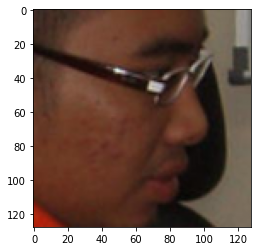

In [7]:
#Here we show one of the images to make sure everything is working
plt.imshow((this_data[10000][:, :, ::-1]).astype(float)/255.0) #for some reason the RGB is reversed
plt.show()

In [8]:
#reading the csv file that contains the labels with pandas
train_label_raw = pd.read_csv("gdrive/MyDrive/DL_big_homework/train.csv")
val_label_raw = pd.read_csv("gdrive/MyDrive/DL_big_homework/val.csv")

In [9]:
#displaying the training labels
train_label_raw.head()

,file,age,gender,race,service_test
0,train/1.jpg,50-59,Male,East Asian,True
1,train/2.jpg,30-39,Female,Indian,False
2,train/3.jpg,3-9,Female,Black,False
3,train/4.jpg,20-29,Female,Indian,True
4,train/5.jpg,20-29,Female,Indian,True


In [10]:
#dispalying the validation labels
val_label_raw.head()

,file,age,gender,race,service_test
0,val/1.jpg,3-9,Male,East Asian,False
1,val/2.jpg,50-59,Female,East Asian,True
2,val/3.jpg,30-39,Male,White,True
3,val/4.jpg,20-29,Female,Latino_Hispanic,True
4,val/5.jpg,20-29,Male,Southeast Asian,False


In [11]:
#Here we used sklearn in order to onehotencode our data thus preparing it for the CNN network
OHEC =OneHotEncoder()
"""
OHEC.fit(X=[["0-2", "Male", "Black", "False"],["3-9", "Female", "Indian", "True"],
["10-19", "Male", "East Asian", "False"],["20-29", "Male", "Southeast Asian", "False"],
["30-39", "Male", "Latino_Hispanic", "False"],["40-49", "Male", "Middle Eastern", "False"],["50-59", "Male", "White", "False"],
["60-69", "Male", "Middel Eastern", "False"],["more than 70", "Male", "White", "False"]])
"""
#The one hot encoder arranges the inputs in alphabetic order
OHEC.fit(val_label_raw[["age", "gender", "race", "service_test"]])
val_label = OHEC.transform(val_label_raw[["age", "gender", "race", "service_test"]]).toarray()
train_label = OHEC.transform(train_label_raw[["age", "gender", "race", "service_test"]]).toarray()
#We are putting thes together inside this npz dataformat
np.savez("labels.npz", train=train_label, val=val_label)

In [ ]:
labels=np.load("labels.npz")

In [ ]:
#Here we are defining the image generetor so that we can use it in our network
#this weill rotate, shear and flip the image so we have more datapoints to use
datagen=ImageDataGenerator(rotation_range=45, width_shift_range=0.2,
                           height_shift_range=0.2,
                           shear_range=0.2, zoom_range=0.2,
                           horizontal_flip=True,
                           fill_mode="constant", cval=128 )

In [ ]:
#We first create a directory
#here we created 5 modified pictures in order to plot them.
#later we will use the image generator in our model as stated before.
!mkdir "modified"
pictures=datagen.flow(this_data[0:5], save_to_dir="[modified]", save_prefix="aug",save_format="png")

In [ ]:
#This function will loadd the images in a given directory
dir_ect=("[modified]")
def load_all_images(directory):
    images = []
    for filename in tqdm(os.listdir(directory)):
        img = cv2.imread(os.path.join(directory,filename))
        if img is not None:
            images.append(img)
    return images

images = load_all_images(dir_ect)       
print(len(images))

  0%|          | 0/11 [00:00<?, ?it/s]

11


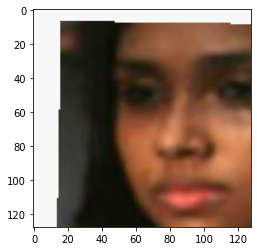

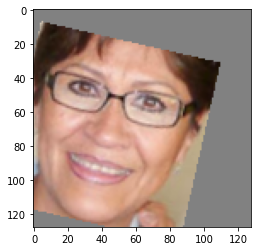

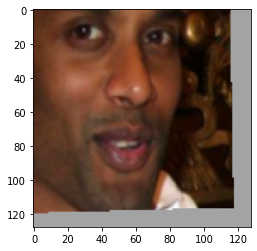

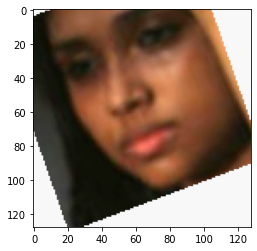

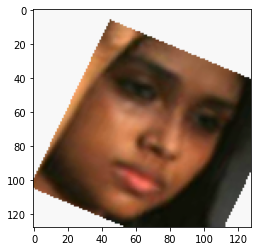

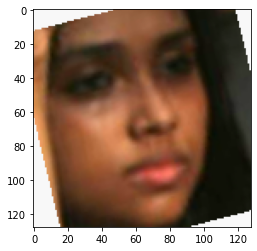

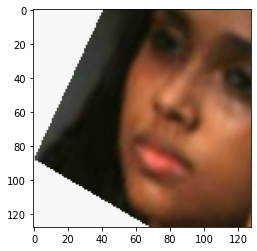

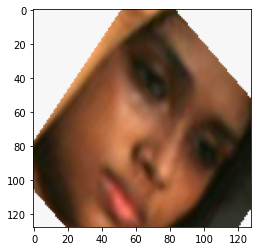

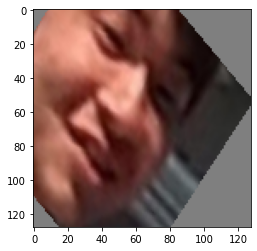

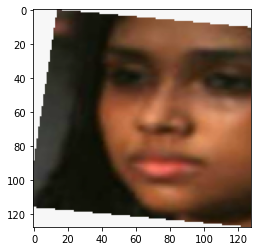

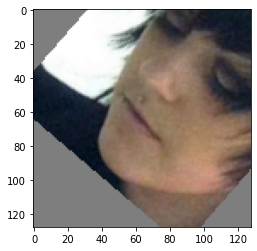

In [ ]:
#lastly this for loop will plot the images inside the loaded images
for i in range(len(images)):
  plt.imshow(images[i])
  plt.show()

In [17]:
start = datetime.now()
embeddings = embedder.embeddings(this_data[:1000, :, :, ::-1]/256)
print(f"This took: {datetime.now()-start}")

This took: 0:00:37.038427


In [18]:
print(embeddings.shape)

(1000, 512)


In [19]:
labels = np.load("labels.npz")["train"][0:1000]
print(labels.shape)

(1000, 20)


In [52]:
valid_embeddings = embedder.embeddings(this_data[1000:1200, :, :, ::-1]/256)
valid_labels = np.load("labels.npz")["train"][1000:1200]

In [21]:
inputs = keras.Input(shape=(embeddings.shape[1],))
x = keras.layers.Dense(128, activation='relu')(inputs)
x = keras.layers.Dropout(0.1)(x)

x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.1)(x)

x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dropout(0.1)(x)

outputs = keras.layers.Dense(labels.shape[1], activation="linear")(x)
model = keras.Model(inputs = inputs, outputs = outputs, name="OpenFace_extension")

model.summary()

Model: "OpenFace_extension"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512)]             0         
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)         

In [33]:
model.compile(
    loss="categorical_crossentropy",
    optimizer="Adam",
    metrics=["accuracy"],
)

In [23]:
batch_size = 32


train_data = tf.data.Dataset.from_tensor_slices((embeddings, labels))
val_data = tf.data.Dataset.from_tensor_slices((valid_embeddings, valid_labels))
train_data = train_data.batch(batch_size)

In [ ]:
model.fit(train_data, validation_data=val_data,epochs=3)

In [34]:
model.fit(embeddings,labels, validation_data=(valid_embeddings, valid_labels),epochs=3)

Epoch 1/3
32/32 [==============================] - 1s 12ms/step - loss: 33.8034 - accuracy: 0.1750 - val_loss: 30.1734 - val_accuracy: 0.3000
Epoch 2/3
32/32 [==============================] - 0s 5ms/step - loss: 32.8003 - accuracy: 0.1270 - val_loss: 35.0903 - val_accuracy: 0.0000e+00
Epoch 3/3
32/32 [==============================] - 0s 5ms/step - loss: 33.0669 - accuracy: 0.0110 - val_loss: 35.0569 - val_accuracy: 0.0000e+00


In [28]:
embeddings.shape

(1000, 512)

In [29]:
labels.shape

(1000, 20)

In [50]:
test_embeddings = embedder.embeddings(this_data[1200:1220, :, :, ::-1]/256)
test_labels=np.load("labels.npz")["train"][1200:1220]

In [55]:
test_embone=embedder.embeddings(this_data[1220:1221, :, :, ::-1]/256)

In [60]:
predictions=model.predict(test_embone)

In [61]:
print(val_label_raw[int(predictions[0][0])])

KeyError: ignored